## Depth Map Analysis

This notebook creates depth maps showing the distance between retinal layers across OCT B-scans.

### Key Features:
- **Dot plot visualization**: X-axis (annotation width), Y-axis (B-scan number), Color (depth)
- **Handles NaN values**: Automatically skips invalid annotation regions
- **Dual visualization**: Both scatter plot and average depth profile
- **High-resolution export**: Saves publication-ready images

### Usage Example:
```python
# List available volumes and layers
volumes = list_available_volumes(names)
print(f"Available layers: {list(layers.keys())}")

# Create depth map for specific volume and layer pair
depth_matrix = create_depth_map(images, layers, names, 'VOLUME_NAME', 
                               layer1='ILM', layer2='BM',
                               save_path="depth_map.png")
```

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.colors import LinearSegmentedColormap

# Load the dataset
path = '/home/suraj/Models/SCR-Progression/e2e/Nemours_Jing_0805.h5'
f = h5py.File(path, 'r')

# Extract data
images = f['images']
layers = f['layers']
names = f['names']

print(f"Dataset shape: Images {images.shape}")
print(f"Available layers: {list(layers.keys())}")
print(f"First few image names: {[names[i].decode('utf-8') for i in range(5)]}")

2025-08-25 12:20:16.666007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756138816.678957   20156 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756138816.683356   20156 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-25 12:20:16.697078: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dataset shape: Images (1266, 496, 768)
Available layers: ['BM', 'ELM', 'GCL', 'ILM', 'INL', 'IPL', 'OPL', 'PR1', 'RPE']
First few image names: ['242_L_1', '242_L_1', '242_L_1', '242_L_1', '242_L_1']


In [12]:
def create_ilm_bm_depth_map(images, layers, names, volume_name, figsize=(12, 8), save_path=None):
    """
    Simple function to create ILM to BM depth map.
    Groups B-scans by exact name match (same volume = same name).
    Color scale: white (0-80 pixels), red-orange-yellow-green-blue (80-160 pixels).
    """
    # Find all B-scans with the same name (same volume)
    volume_indices = []
    for i, name in enumerate(names):
        name_str = name.decode('utf-8')
        if name_str == volume_name:
            volume_indices.append(i)
    
    print(f"Volume '{volume_name}': Found {len(volume_indices)} B-scans")
    
    if len(volume_indices) == 0:
        print(f"No B-scans found for volume '{volume_name}'")
        return None
    
    # Calculate ILM to BM distance for each B-scan
    num_bscans = len(volume_indices)
    width = 768
    
    x_coords = []
    y_coords = []
    distances = []
    
    for bscan_idx, data_idx in enumerate(volume_indices):
        ilm_coords = layers['ILM'][data_idx]
        bm_coords = layers['BM'][data_idx]
        
        # Calculate distance for each x coordinate, skip NaN values
        for x_idx in range(width):
            ilm_y = ilm_coords[x_idx]
            bm_y = bm_coords[x_idx]
            
            # Skip if either coordinate is NaN
            if not (np.isnan(ilm_y) or np.isnan(bm_y)):
                distance = abs(bm_y - ilm_y)
                x_coords.append(x_idx)
                y_coords.append(bscan_idx)
                distances.append(distance)
    
    # After collecting x_coords, y_coords, distances
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)
    distances = np.array(distances)
    
    # Replace depth value with np.nan if x-coordinate is 0 and distance is 0
    zero_at_x0 = (x_coords == 0) & (distances == 0)
    distances[zero_at_x0] = np.nan

    # Filter out zero distances
    nonzero_mask = (distances != 0) & (~np.isnan(distances))
    x_coords = x_coords[nonzero_mask]
    y_coords = y_coords[nonzero_mask]
    distances = distances[nonzero_mask]
    
    # Create visualization
    fig, ax = plt.subplots(figsize=figsize)
    
    # Find min and max distance values for color mapping
    min_distance = np.min(distances)
    max_distance = np.max(distances)
    
    # Create scatter plot
    scatter = ax.scatter(x_coords, y_coords, c=distances, cmap='viridis', 
                        s=3, alpha=0.9, vmin=min_distance, vmax=max_distance)
    
    ax.set_xlabel('X coordinate (pixels)')
    ax.set_ylabel('B-scan index')
    ax.set_title(f'ILM to BM Distance for Volume: {volume_name}')
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Depth (pixels)')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print statistics
    print(f"\\nDistance Statistics:")
    print(f"Valid measurements: {len(distances):,}")
    print(f"Min distance: {min_distance:.2f} pixels")
    print(f"Max distance: {max_distance:.2f} pixels")
    print(f"Mean distance: {np.mean(distances):.2f} ± {np.std(distances):.2f} pixels")
    
    return np.array(distances)

In [13]:
def create_ilm_bm_heatmap(layers, names, volume_name, figsize=(12, 8), save_path=None):
    """
    Create a heatmap visualization of ILM to BM distance for a specific volume.
    Groups B-scans by exact name match (same volume = same name).
    """
    # Find all B-scans with the same name (same volume)
    volume_indices = []
    for i, name in enumerate(names):
        name_str = name.decode('utf-8')
        if name_str == volume_name:
            volume_indices.append(i)
    
    print(f"Volume '{volume_name}': Found {len(volume_indices)} B-scans")
    
    if len(volume_indices) == 0:
        print(f"No B-scans found for volume '{volume_name}'")
        return None
    
    # Calculate ILM to BM distance for each B-scan
    num_bscans = len(volume_indices)
    width = 768
    
    # Initialize distance matrix with NaN
    distance_matrix = np.full((num_bscans, width), np.nan)
    
    for bscan_idx, data_idx in enumerate(volume_indices):
        ilm_coords = layers['ILM'][data_idx]
        bm_coords = layers['BM'][data_idx]
        
        # Calculate distance for each x coordinate
        for x_idx in range(width):
            ilm_y = ilm_coords[x_idx]
            bm_y = bm_coords[x_idx]
            
            # Skip if either coordinate is NaN
            if not (np.isnan(ilm_y) or np.isnan(bm_y)):
                distance = abs(bm_y - ilm_y)
                distance_matrix[bscan_idx, x_idx] = distance
    
    # Replace depth value with np.nan if x-coordinate is 0 and distance is 0
    zero_x0_mask = distance_matrix[:, 0] == 0
    distance_matrix[zero_x0_mask, 0] = np.nan
    
    # Create visualization
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    # Mask NaN values for better visualization
    masked_matrix = np.ma.masked_invalid(distance_matrix)
    
    # Find min and max distance values for color mapping (excluding NaN)
    valid_distances = distance_matrix[~np.isnan(distance_matrix)]
    min_distance = np.min(valid_distances)
    max_distance = np.max(valid_distances)
    
    # Create heatmap
    im = ax.imshow(masked_matrix, cmap='viridis', aspect='auto', 
                   vmin=min_distance, vmax=max_distance, origin='lower')
    
    ax.set_xlabel('X coordinate (pixels)')
    ax.set_ylabel('B-scan index')
    ax.set_title(f'ILM to BM Distance Heatmap for Volume: {volume_name}')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Depth (pixels)')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print statistics
    print(f"\nDistance Statistics:")
    print(f"Valid measurements: {len(valid_distances):,}")
    print(f"Min distance: {min_distance:.2f} pixels")
    print(f"Max distance: {max_distance:.2f} pixels")
    print(f"Mean distance: {np.mean(valid_distances):.2f} ± {np.std(valid_distances):.2f} pixels")
    
    return distance_matrix

In [14]:
def list_unique_volumes(names, max_display=10):
    """List unique volume names in the dataset"""
    unique_names = {}
    for i, name in enumerate(names):
        name_str = name.decode('utf-8')
        if name_str not in unique_names:
            unique_names[name_str] = []
        unique_names[name_str].append(i)
    
    print(f"Unique volumes ({len(unique_names)} total):")
    displayed = 0
    for vol_name, indices in unique_names.items():
        if displayed < max_display:
            print(f"  '{vol_name}': {len(indices)} B-scans")
            displayed += 1
        elif displayed == max_display:
            print(f"  ... and {len(unique_names) - max_display} more volumes")
            break
    
    return list(unique_names.keys())

In [6]:
# List unique volume names and create ILM to BM depth map
volume_names = list_unique_volumes(names)

Unique volumes (41 total):
  '242_L_1': 31 B-scans
  '247_L_1_1': 31 B-scans
  '244_R_2': 31 B-scans
  '237_R_1': 31 B-scans
  '240_L_1': 31 B-scans
  '248_R_1_2': 31 B-scans
  '250_L_1': 31 B-scans
  '245_L_1_2': 31 B-scans
  '249_R_1': 31 B-scans
  '239_R_1': 31 B-scans
  ... and 31 more volumes


Unique volumes (41 total):
  '242_L_1': 31 B-scans
  '247_L_1_1': 31 B-scans
  '244_R_2': 31 B-scans
  '237_R_1': 31 B-scans
  '240_L_1': 31 B-scans
  '248_R_1_2': 31 B-scans
  '250_L_1': 31 B-scans
  '245_L_1_2': 31 B-scans
  '249_R_1': 31 B-scans
  '239_R_1': 31 B-scans
  ... and 31 more volumes
Creating ILM to BM depth map
Volume '245_L_1_2': Found 31 B-scans


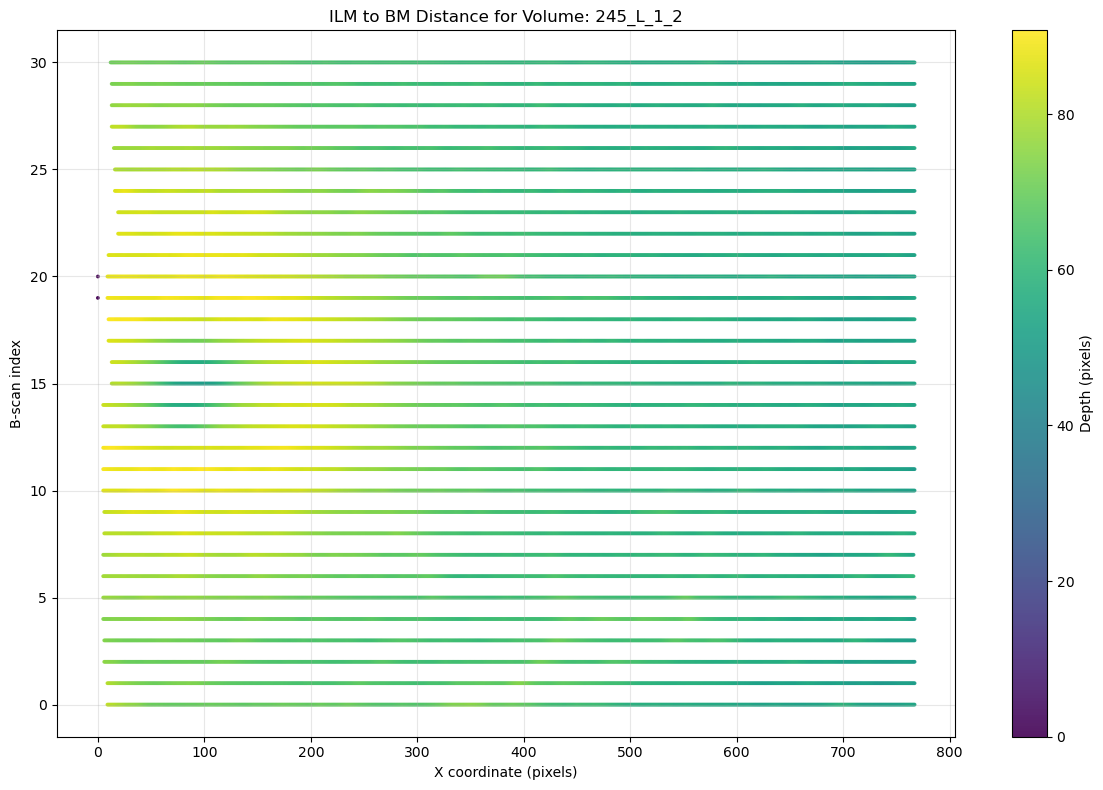

\nDistance Statistics:
Valid measurements: 23,511
Min distance: 0.00 pixels
Max distance: 90.76 pixels
Mean distance: 65.60 ± 10.10 pixels
Creating ILM to BM heatmap
Volume '245_L_1_2': Found 31 B-scans


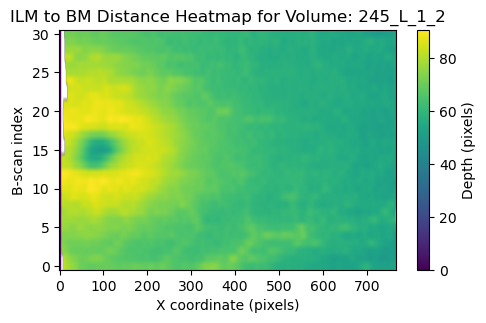


Distance Statistics:
Valid measurements: 23,635
Min distance: 0.00 pixels
Max distance: 90.76 pixels
Mean distance: 65.26 ± 11.14 pixels


In [23]:
# List unique volume names and create ILM to BM depth map
volume_names = list_unique_volumes(names)

# Create depth map for a specific volume
print("="*50)
print("Creating ILM to BM depth map")
print("="*50)

# Use the first available volume name
selected_volume = "245_L_1_2"
#selected_volume = volume_names[0] if volume_names else "240_L"
distances = create_ilm_bm_depth_map(images, layers, names, selected_volume, 
                                   save_path="DepthMap_245_L_1_2.png")
print("="*50)
print("Creating ILM to BM heatmap")
print("="*50)
heatmap = create_ilm_bm_heatmap(layers, names, selected_volume, figsize=(5, 3.334), save_path="HeatMap_245_L_1_2.png")

\n==================================================
Creating depth map for another volume
Volume '248_R_1_2': Found 31 B-scans


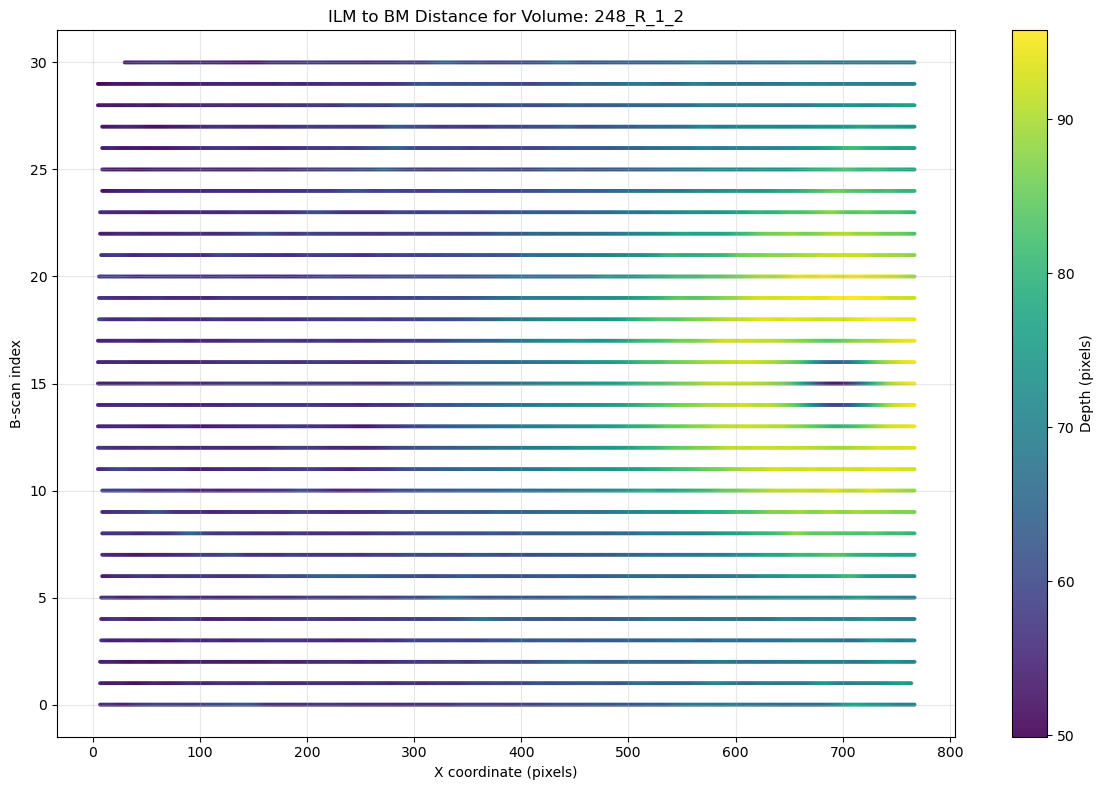

\nDistance Statistics:
Valid measurements: 23,564
Min distance: 49.90 pixels
Max distance: 95.78 pixels
Mean distance: 65.92 ± 11.27 pixels


In [9]:
# Try another volume to see color variation
print("\\n" + "="*50)
print("Creating depth map for another volume")
print("="*50)

# Select a different volume
if len(volume_names) > 5:
    selected_volume2 = volume_names[5]
    distances2 = create_ilm_bm_depth_map(images, layers, names, selected_volume2, 
                                        save_path="ilm_bm_depth_map2.png")

In [ ]:
# Create heatmap visualization for the same volume
print("\n" + "="*50)
print("Creating ILM to BM HEATMAP")
print("="*50)

# Use the same volume as before for comparison
selected_volume = volume_names[0] if volume_names else "240_L"
distance_matrix = create_ilm_bm_heatmap(images, layers, names, selected_volume, 
                                       save_path="depth_map_ILM_BM.png")

## Summary

✅ **ILM to BM depth visualization with multiple options:**

### 🎯 **Key Features:**
- **Measures distance** between ILM and BM layers for each volume
- **Groups B-scans** by exact name match (same volume = same name)
- **Skips NaN values** automatically during distance calculation
- **Multiple visualization types**: Scatter plot, heatmap, and combined view

### 📊 **Visualization Options:**

#### 1. **Scatter Plot** (`create_ilm_bm_depth_map`)
- **X-axis**: X coordinate (0-768 pixels)
- **Y-axis**: B-scan index (0-30 for each volume)
- **Color**: Distance between ILM and BM layers (viridis colormap)
- **Points**: Each valid measurement as a colored dot

#### 2. **Heatmap** (`create_ilm_bm_heatmap`)
- **X-axis**: X coordinate (0-768 pixels)
- **Y-axis**: B-scan index (0-30 for each volume)
- **Color**: Distance between ILM and BM layers (viridis colormap)
- **Format**: Continuous heatmap showing spatial patterns



### 🔧 **Usage Examples:**
```python
# List available volumes
volume_names = list_unique_volumes(names)

# Create scatter plot
distances = create_ilm_bm_depth_map(images, layers, names, 'VOLUME_NAME')

# Create heatmap
matrix = create_ilm_bm_heatmap(images, layers, names, 'VOLUME_NAME')

```

### 📈 **Results:**
- **Scatter plots**: Great for seeing individual data points and density patterns
- **Heatmaps**: Excellent for visualizing continuous spatial patterns and trends
- **Automatic color scaling**: Optimal contrast for each visualization type

Plotting sample image with layer annotations


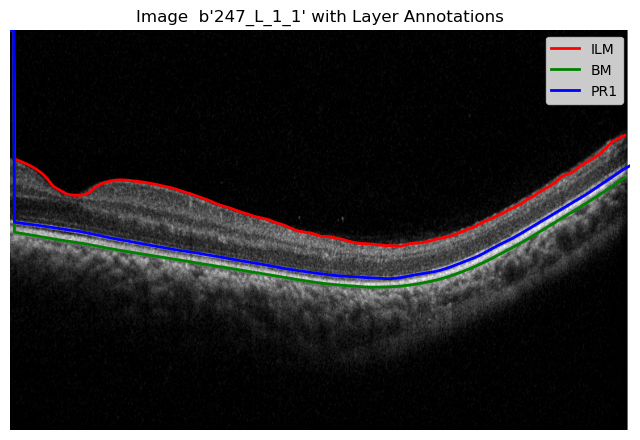

In [12]:
# Plot a sample image with ILM and BM layer annotations from the same volume
print("="*50)
print("Plotting sample image with layer annotations")
print("="*50)   
# Plot image 0 with ILM, BM, and PR1 layer annotations  

img0 = images[45]

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img0, cmap='gray')
ax.set_title(f'Image  {names[45]} with Layer Annotations')
ax.axis('off')

for layer_name, color in zip(['ILM', 'BM', 'PR1'], ['r', 'g', 'b']):
    coords = layers[layer_name][45]  # shape: (width,) or (width, 2)
    if coords.ndim == 1:
        # If only y-coordinates, x is just np.arange
        x = np.arange(coords.shape[0])
        y = coords
    else:
        # If (x, y) pairs
        x, y = coords[:, 0], coords[:, 1]
    ax.plot(x, y, color=color, label=layer_name, linewidth=2)

ax.legend()
plt.show()

In [ ]:
"""
Heatmap Inference Script for CNN Layer Regression Model

This script:
1. Loads the Nemours dataset
2. Uses a trained CNN regression model to predict layer coordinates (ILM and BM)
3. Creates heatmaps for predicted annotations similar to ground truth
4. Compares predicted vs ground truth heatmaps for each volume

Usage:
    python seq2seq_heatmap_inference.py
"""

import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage.transform import resize
from datetime import datetime
from tqdm import tqdm


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class LayerAnnotationCNN(nn.Module):
    """Regression model architecture from CNN_model_inference.py"""
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 224 * 2)  # Output: (batch_size, 224*2) -> reshaped to (224, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        x = x.view(-1, 224, 2)  # Output shape: (batch_size, 224, 2) for [ILM, BM] coords
        return x


class InferenceDataset(Dataset):
    """Dataset for inference"""
    def __init__(self, images):
        self.images = images.astype(np.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        # Add channel dimension and transpose to (C, H, W) for PyTorch
        if img.ndim == 2:
            img = np.expand_dims(img, axis=0)
        elif img.ndim == 3:
            img = np.transpose(img, (2, 0, 1))
        return torch.from_numpy(img)


def load_nemours_dataset(hdf5_path, target_size=(224, 224)):
    """
    Load Nemours dataset and return images, ground truth layers, and names
    """
    with h5py.File(hdf5_path, 'r') as f:
        # Load original data
        images_orig = f['images'][:]  # Shape: (N, 496, 768)
        layers = f['layers']
        names = f['names'][:]
        
        # Extract layer data
        layer_data = {
            'ILM': layers['ILM'][:],
            'PR1': layers['PR1'][:],
            'BM': layers['BM'][:]
        }
    
    print(f"Original image shape: {images_orig.shape}")
    print(f"Available layers: {list(layer_data.keys())}")
    
    # Resize images to target size for model inference
    resized_images = []
    for i in range(images_orig.shape[0]):
        img = images_orig[i]
        resized_img = resize(img, target_size, preserve_range=True, anti_aliasing=True)
        # Normalize to [0, 1]
        if resized_img.max() > 1.0:
            resized_img = resized_img / 255.0
        resized_images.append(resized_img)
    
    images = np.array(resized_images)
    
    # Decode names
    volume_names = [name.decode('utf-8') for name in names]
    
    return images, layer_data, volume_names, images_orig


def convert_regression_to_coordinates(predictions, original_size=(496, 768)):
    """
    Convert regression predictions directly to layer coordinates
    
    Args:
        predictions: Model predictions of shape (N, 224, 2) where 2 = [ILM, BM] normalized coords
        original_size: Target size to scale coordinates to
    
    Returns:
        dict: Layer coordinates scaled to original image size
    """
    num_images = predictions.shape[0]
    orig_height, orig_width = original_size
    
    # Initialize coordinate arrays
    ilm_coords = np.full((num_images, orig_width), np.nan)
    bm_coords = np.full((num_images, orig_width), np.nan)
    
    # Convert predictions to numpy if needed
    if hasattr(predictions, 'cpu'):
        predictions = predictions.cpu().numpy()
    
    for i in range(num_images):
        pred_coords = predictions[i]  # Shape: (224, 2)
        
        # Scale from model output width (224) to original width (768)
        for model_x in range(pred_coords.shape[0]):  # 224 points
            # Map model x-coordinate to original x-coordinate
            orig_x = int((model_x / 224.0) * orig_width)
            
            if orig_x < orig_width:
                # Get normalized coordinates [0, 1] and scale to original height
                ilm_y_norm = pred_coords[model_x, 0]
                bm_y_norm = pred_coords[model_x, 1]
                
                # Skip if coordinates are invalid
                if not (np.isnan(ilm_y_norm) or np.isnan(bm_y_norm)):
                    # Scale to original image height
                    ilm_y = ilm_y_norm * orig_height
                    bm_y = bm_y_norm * orig_height
                    
                    # Clip to valid range
                    ilm_y = np.clip(ilm_y, 0, orig_height - 1)
                    bm_y = np.clip(bm_y, 0, orig_height - 1)
                    
                    ilm_coords[i, orig_x] = ilm_y
                    bm_coords[i, orig_x] = bm_y
        
        # Interpolate missing values for smoother curves
        for coord_array in [ilm_coords[i], bm_coords[i]]:
            valid_indices = ~np.isnan(coord_array)
            if np.sum(valid_indices) > 1:
                # Interpolate NaN values
                x_valid = np.where(valid_indices)[0]
                y_valid = coord_array[valid_indices]
                x_all = np.arange(orig_width)
                coord_array[:] = np.interp(x_all, x_valid, y_valid, 
                                         left=np.nan, right=np.nan)
    
    return {
        'ILM': ilm_coords,
        'BM': bm_coords
    }


def create_predicted_heatmap(pred_layers, names, volume_name, figsize=(12, 8), save_path=None):
    """
    Create heatmap from predicted layer coordinates (similar to create_ilm_bm_heatmap)
    """
    # Find all B-scans with the same name (same volume)
    volume_indices = []
    for i, name in enumerate(names):
        if name == volume_name:
            volume_indices.append(i)
    
    print(f"Volume '{volume_name}': Found {len(volume_indices)} B-scans")
    
    if len(volume_indices) == 0:
        print(f"No B-scans found for volume '{volume_name}'")
        return None
    
    # Calculate ILM to BM distance for each B-scan
    num_bscans = len(volume_indices)
    width = pred_layers['ILM'].shape[1]  # Should be 768 for original size
    
    # Initialize distance matrix with NaN
    distance_matrix = np.full((num_bscans, width), np.nan)
    
    for bscan_idx, data_idx in enumerate(volume_indices):
        ilm_coords = pred_layers['ILM'][data_idx]
        bm_coords = pred_layers['BM'][data_idx]
        
        # Calculate distance for each x coordinate
        for x_idx in range(width):
            ilm_y = ilm_coords[x_idx]
            bm_y = bm_coords[x_idx]
            
            # Skip if either coordinate is NaN
            if not (np.isnan(ilm_y) or np.isnan(bm_y)):
                distance = abs(bm_y - ilm_y)
                distance_matrix[bscan_idx, x_idx] = distance
    
    # Create visualization
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap - mask NaN values for better visualization
    masked_matrix = np.ma.masked_invalid(distance_matrix)
    
    # Find min and max distance values for color mapping (excluding NaN)
    valid_distances = distance_matrix[~np.isnan(distance_matrix)]
    
    if len(valid_distances) == 0:
        print(f"No valid distances found for volume '{volume_name}'")
        return None
    
    min_distance = np.min(valid_distances)
    max_distance = np.max(valid_distances)
    
    # Create heatmap
    im = ax.imshow(masked_matrix, cmap='viridis', aspect='auto', 
                   vmin=min_distance, vmax=max_distance, origin='lower')
    
    ax.set_xlabel('X coordinate (pixels)')
    ax.set_ylabel('B-scan index')
    ax.set_title(f'Predicted ILM to BM Distance Heatmap for Volume: {volume_name}')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Depth (pixels)')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print statistics
    print(f"\nPredicted Distance Statistics:")
    print(f"Valid measurements: {len(valid_distances):,}")
    print(f"Min distance: {min_distance:.2f} pixels")
    print(f"Max distance: {max_distance:.2f} pixels")
    print(f"Mean distance: {np.mean(valid_distances):.2f} ± {np.std(valid_distances):.2f} pixels")
    
    return distance_matrix


def create_ground_truth_heatmap(gt_layers, names, volume_name, figsize=(12, 8), save_path=None):
    """
    Create heatmap from ground truth layer coordinates (from data_ops.ipynb)
    """
    # Find all B-scans with the same name (same volume)
    volume_indices = []
    for i, name in enumerate(names):
        if name == volume_name:
            volume_indices.append(i)
    
    print(f"Volume '{volume_name}': Found {len(volume_indices)} B-scans")
    
    if len(volume_indices) == 0:
        print(f"No B-scans found for volume '{volume_name}'")
        return None
    
    # Calculate ILM to BM distance for each B-scan
    num_bscans = len(volume_indices)
    width = 768
    
    # Initialize distance matrix with NaN
    distance_matrix = np.full((num_bscans, width), np.nan)
    
    for bscan_idx, data_idx in enumerate(volume_indices):
        ilm_coords = gt_layers['ILM'][data_idx]
        bm_coords = gt_layers['BM'][data_idx]
        
        # Calculate distance for each x coordinate
        for x_idx in range(width):
            ilm_y = ilm_coords[x_idx]
            bm_y = bm_coords[x_idx]
            
            # Skip if either coordinate is NaN
            if not (np.isnan(ilm_y) or np.isnan(bm_y)):
                distance = abs(bm_y - ilm_y)
                distance_matrix[bscan_idx, x_idx] = distance
    
    # Replace depth value with np.nan if x-coordinate is 0 and distance is 0
    zero_x0_mask = distance_matrix[:, 0] == 0
    distance_matrix[zero_x0_mask, 0] = np.nan
    
    # Create visualization
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap - mask NaN values for better visualization
    masked_matrix = np.ma.masked_invalid(distance_matrix)
    
    # Find min and max distance values for color mapping (excluding NaN)
    valid_distances = distance_matrix[~np.isnan(distance_matrix)]
    min_distance = np.min(valid_distances)
    max_distance = np.max(valid_distances)
    
    # Create heatmap
    im = ax.imshow(masked_matrix, cmap='viridis', aspect='auto', 
                   vmin=min_distance, vmax=max_distance, origin='lower')
    
    ax.set_xlabel('X coordinate (pixels)')
    ax.set_ylabel('B-scan index')
    ax.set_title(f'Ground Truth ILM to BM Distance Heatmap for Volume: {volume_name}')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Depth (pixels)')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Print statistics
    print(f"\nGround Truth Distance Statistics:")
    print(f"Valid measurements: {len(valid_distances):,}")
    print(f"Min distance: {min_distance:.2f} pixels")
    print(f"Max distance: {max_distance:.2f} pixels")
    print(f"Mean distance: {np.mean(valid_distances):.2f} ± {np.std(valid_distances):.2f} pixels")
    
    return distance_matrix


def list_unique_volumes(names, max_display=10):
    """List unique volume names in the dataset"""
    unique_names = {}
    for i, name in enumerate(names):
        if name not in unique_names:
            unique_names[name] = []
        unique_names[name].append(i)
    
    print(f"Unique volumes ({len(unique_names)} total):")
    displayed = 0
    for vol_name, indices in unique_names.items():
        if displayed < max_display:
            print(f"  '{vol_name}': {len(indices)} B-scans")
            displayed += 1
        elif displayed == max_display:
            print(f"  ... and {len(unique_names) - max_display} more volumes")
            break
    
    return list(unique_names.keys())


def run_inference_and_create_heatmaps(model_path, dataset_path, output_dir="depth-map"):
    """
    Main function to run inference and create heatmaps
    """
    # Create output directory
    timestamp = datetime.now().strftime("%m%d_%H%M")
    # results should be saved as depth-map/<timestamp>/
    results_dir = f"{output_dir}/{timestamp}"
    os.makedirs(results_dir, exist_ok=True)
    print(f"Results will be saved to: {results_dir}")
    
    # Load model
    print("Loading trained regression model...")
    model = LayerAnnotationCNN().to(device)
    
    try:
        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
        model.eval()
        print(f"✓ Model loaded successfully from {model_path}")
    except Exception as e:
        print(f"✗ Error loading model: {e}")
        return
    
    # Load dataset
    print("Loading Nemours dataset...")
    images, gt_layers, volume_names, original_images = load_nemours_dataset(dataset_path)
    print(f"✓ Loaded {len(images)} images")
    
    # List available volumes
    unique_volumes = list_unique_volumes(volume_names)
    
    # Create inference dataset and dataloader
    dataset = InferenceDataset(images)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=False)
    
    # Run inference to get predicted coordinates
    print("Running inference to get predicted layer coordinates...")
    all_predictions = []
    
    with torch.no_grad():
        for batch_images in tqdm(dataloader, desc="Inference"):
            batch_images = batch_images.to(device)
            
            # Get model predictions - direct coordinate output
            outputs = model(batch_images)  # Shape: (batch_size, 224, 2)
            
            # Move to CPU and store
            all_predictions.append(outputs.cpu())
    
    # Concatenate all predictions
    all_predictions = torch.cat(all_predictions, dim=0)
    print(f"✓ Generated predictions for {len(all_predictions)} images")
    print(f"Prediction shape: {all_predictions.shape}")
    
    # Convert regression predictions to layer coordinates
    print("Converting predictions to layer coordinates...")
    pred_layers = convert_regression_to_coordinates(all_predictions, original_size=(496, 768))
    print(f"✓ Converted to coordinate format")
    
    # Create heatmaps for a few sample volumes
    sample_volumes = unique_volumes[:3]  # First 3 volumes
    
    for vol_name in sample_volumes:
        print(f"\n{'='*60}")
        print(f"Creating heatmaps for volume: {vol_name}")
        print(f"{'='*60}")
        
        # Create ground truth heatmap
        gt_save_path = os.path.join(results_dir, f"gt_heatmap_{vol_name}.png")
        gt_matrix = create_ground_truth_heatmap(
            gt_layers, volume_names, vol_name, 
            figsize=(12, 6), save_path=gt_save_path
        )
        
        # Create predicted heatmap
        pred_save_path = os.path.join(results_dir, f"pred_heatmap_{vol_name}.png")
        pred_matrix = create_predicted_heatmap(
            pred_layers, volume_names, vol_name, 
            figsize=(12, 6), save_path=pred_save_path
        )
        
        # Create comparison plot
        if gt_matrix is not None and pred_matrix is not None:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
            
            # Ground truth
            gt_masked = np.ma.masked_invalid(gt_matrix)
            gt_valid = gt_matrix[~np.isnan(gt_matrix)]
            im1 = ax1.imshow(gt_masked, cmap='viridis', aspect='auto', 
                           vmin=np.min(gt_valid), vmax=np.max(gt_valid), origin='lower')
            ax1.set_title(f'Ground Truth: {vol_name}')
            ax1.set_xlabel('X coordinate (pixels)')
            ax1.set_ylabel('B-scan index')
            plt.colorbar(im1, ax=ax1, label='Depth (pixels)')
            
            # Predicted
            pred_masked = np.ma.masked_invalid(pred_matrix)
            pred_valid = pred_matrix[~np.isnan(pred_matrix)]
            if len(pred_valid) > 0:
                im2 = ax2.imshow(pred_masked, cmap='viridis', aspect='auto', 
                               vmin=np.min(pred_valid), vmax=np.max(pred_valid), origin='lower')
                ax2.set_title(f'Predicted: {vol_name}')
                ax2.set_xlabel('X coordinate (pixels)')
                ax2.set_ylabel('B-scan index')
                plt.colorbar(im2, ax=ax2, label='Depth (pixels)')
            else:
                ax2.text(0.5, 0.5, 'No valid predictions', ha='center', va='center', 
                        transform=ax2.transAxes, fontsize=16)
                ax2.set_title(f'Predicted: {vol_name} (No valid data)')
            
            plt.tight_layout()
            comparison_path = os.path.join(results_dir, f"comparison_{vol_name}.png")
            plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
            plt.show()
    
    print(f"\n✅ Heatmap generation completed!")
    print(f"📁 Results saved to: {results_dir}")
    print(f"📊 Generated heatmaps for {len(sample_volumes)} volumes")


def main():
    """Main execution function"""
    # Configuration
    MODEL_PATH = "/home/suraj/Git/SCR-Progression/CNN-Model/CNN_pytorch_model.pth"
    DATASET_PATH = "/home/suraj/Models/SCR-Progression/e2e/Nemours_Jing_0805.h5"
    
    print("🔬 CNN Regression Heatmap Inference Script")
    print("=" * 50)
    print(f"Model: {MODEL_PATH}")
    print(f"Dataset: {DATASET_PATH}")
    print(f"Device: {device}")
    print("=" * 50)
    
    # Run inference and create heatmaps
    run_inference_and_create_heatmaps(MODEL_PATH, DATASET_PATH)


if __name__ == "__main__":
    main()
